# COMP30810 Intro to Text Analytics 2018
# Homework 2

In [85]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import wordcloud as wc
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Pre-Processing:

### Load data into Dataframe

In [86]:
df_handle = pd.read_csv('trainingset.csv',sep='^',header=0)
df_handle.head()

,content,category
0,French boss to leave EADS The French co-head o...,business
1,"Gamers could drive high-definition TV, films, ...",tech
2,Stalemate in pension strike talks Talks aimed ...,politics
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment
4,Tautou 'to star in Da Vinci film' French actre...,entertainment


# Tokenization
### Extract Tokens from Raw Text

In [87]:
def extract_tokens(rawtext):
    """Split raw text into tokens."""
    pattern = r'\w+'
    tokenizer = RegexpTokenizer(pattern)
    return tokenizer.tokenize(rawtext)

### Remove Stop Words

In [88]:
stopwords_nltk_en = set(stopwords.words('english'))
# Combine nltk stopwords with some extra ones
STOP_WORDS = stopwords_nltk_en.union({"a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"})

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in STOP_WORDS]

### Remove Capitalization

In [89]:
 def decapitalize(tokens):
    return [word.lower() for word in tokens]

### Remove Salutation

In [90]:
SALUTATIONS = ('mr','mrs','mss','dr','phd','prof','rev','professor')

def remove_salutations(tokens):
    return [word for word in tokens if word.lower() not in SALUTATIONS]

### Remove Numbers

In [91]:
def remove_numbers(tokens):
    return [word for word in tokens if not word.isdigit()]         

### Lemmatization

In [92]:
def transfer_tag(treebank_tag):
    if treebank_tag.startswith('j' or 'J'):
        return 'a'
    elif treebank_tag.startswith('v' or 'V'):
        return 'v'
    elif treebank_tag.startswith('n' or 'N'):
        return 'n'
    elif treebank_tag.startswith('r' or 'R'):
        return 'r'
    else:
        # As default pos in lemmatization is Noun
        return 'n' 

In [93]:
def lemmatize(tokens):
    wnl = WordNetLemmatizer()
    lemma_words = []
    for word, tag in nltk.pos_tag(tokens):
        firstletter = tag[0].lower() # -> get the first letter of tag and put them decapitalized form
        wtag = transfer_tag(firstletter) # -> extract the word's tag (noun, verb, adverb, adjective)
        lemma_words.append(wnl.lemmatize(word, wtag) if len(word)>2 else word) # -> get lemma for word with tag

    return lemma_words

In [94]:
def tokenize(rawtext):
    return lemmatize(
         remove_numbers(
             remove_salutations(
                 remove_stopwords(
                     decapitalize(
                         extract_tokens(
                             rawtext))))))

## Testing the Tokenizer
We'll test the tokenizer on a short sample of text to check for any issues:

In [95]:
sample_text = df_handle.content[0][:201]
print(sample_text)
print(tokenize(sample_text))

French boss to leave EADS The French co-head of European defence and aerospace group EADS Philippe Camus is to leave his post. Mr Camus said in a statement that he has accepted the invitation to return
['french', 'bos', 'leave', 'eads', 'french', 'head', 'european', 'defence', 'aerospace', 'group', 'eads', 'philippe', 'camus', 'leave', 'post', 'camus', 'statement', 'accept', 'invitation', 'return']


The results look fine except for the second token 'bos', which should be 'boss'. This is because the lemmatizer thinks that 'boss' is a plural, and so converts it to the singular form 'bos':

In [96]:
lemmatize(['boss'])

['bos']

This is a bug in the lemmatizer, so we cannot fix it. Despite this minor issue, we will continue to use lemmatization as it is very useful even if it sometimes makes mistakes.

### Applying tokenization

In [97]:
df_handle['tokens'] = df_handle['content'].apply(tokenize)
df_handle.head()

,content,category,tokens
0,French boss to leave EADS The French co-head o...,business,"[french, bos, leave, eads, french, head, europ..."
1,"Gamers could drive high-definition TV, films, ...",tech,"[gamers, drive, high, definition, tv, film, ga..."
2,Stalemate in pension strike talks Talks aimed ...,politics,"[stalemate, pension, strike, talk, talk, aim, ..."
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[johnny, denise, lose, passport, johnny, vaugh..."
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[tautou, star, da, vinci, film, french, actres..."


## Tokens Analysis

Now we turn our attention to exploring and analysing the data that we have cleaned, transformed, tokenized and saved into our data frame. In particular, we will investigate the tokens columns that we have constructed. We will look at the following features:
- Most-Common N-Grams
- Category Frequency and Imbalance
- Distribution of Document Lengths

### Most-Common N-Grams

We start our analysis by look at the most common words and phrases in the corpus. This will give us a better feel for the data that we are dealing with and may give us some useful insights into  particular words or phrases our classifier should pay most attention to.

We will also analyse the best ways to visualise our results, comparing word clouds with simple bar charts.

#### Word Cloud

We explore our corpus by looking at which words and phrases are most common. One popular way of doing this is by creating a word cloud from the corpus data.

We create the wordcloud image using the `wordcloud` library and plot it. 
<br />
We are also saving it to a file called *corpus_wordcloud.png*.

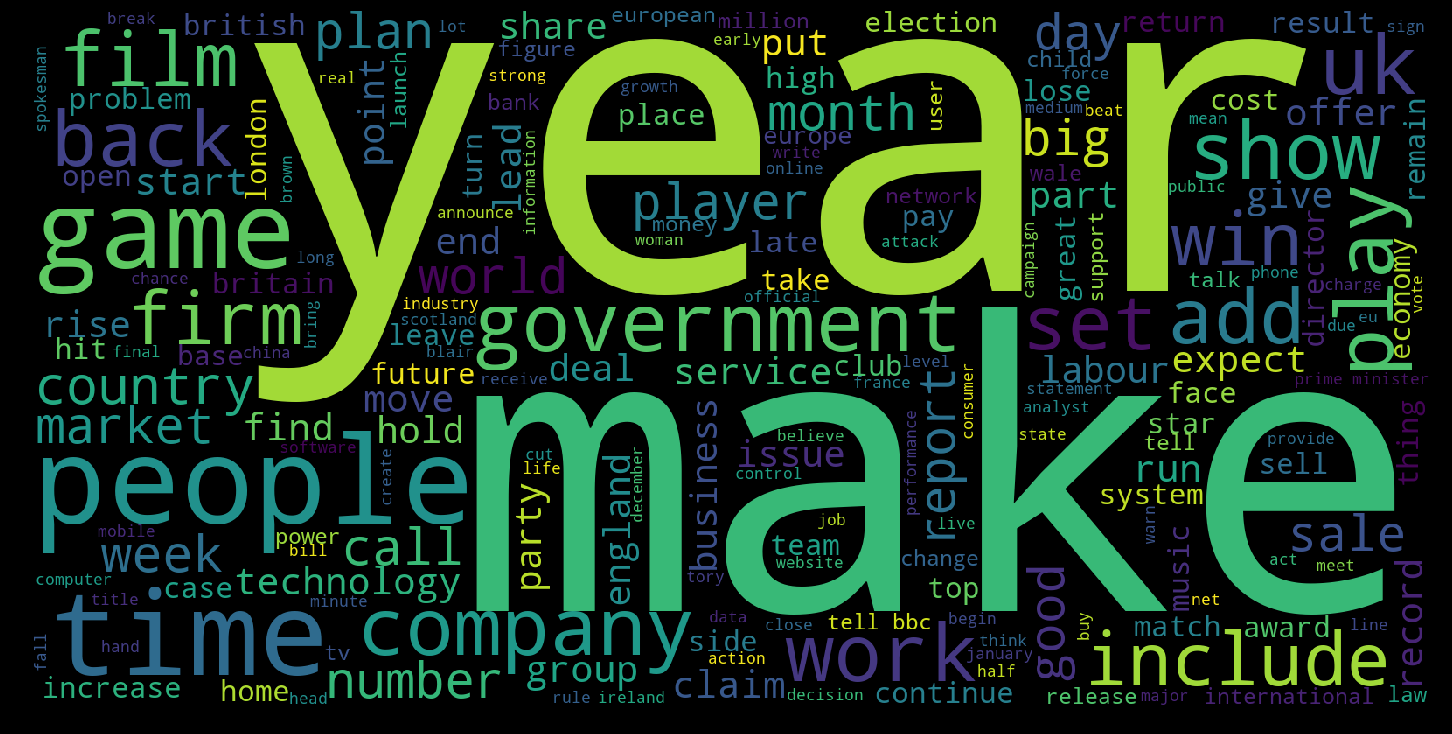

In [98]:
# Get all the tokens from our data.
all_tokens_list = [token for tokens in df_handle['tokens'] for token in tokens]

# The word cloud uses a single string not a list, so we convert our 
# list of tokens to a single string.
all_tokens_string = " ".join(all_tokens_list)

# Create the WordCloud object from the string of tokens.
wordcloud = wc.WordCloud(width=1600, height=800).generate(all_tokens_string)

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Save the word cloud image to a file.
wordcloud.to_file("images/corpus_wordcloud.png")

# Delete this to clean up our notebook.
del all_tokens_list

From the word cloud, a number of words stand out above the rest, for example "year", "make" and "people". Due to their bigger size, we can conclude that they are the most frequent words in our corpus. However, it is hard to draw much more conclusions from the word cloud. There are a number of problems associated with it:
- The length of words in the word cloud biases our perception of it. For example, longer words like "government" stand out more than other smaller words that have roughly the same size, e.g. "uk".
- Furthermore, it is quite hard to judge the font size of each word. Obviously, when there is a big difference we can distinguish it, but it is hard to make judgements in subtler cases. This is particularly true when words are plotted far apart in the word cloud. For instance, which word is more common, "market" or "world"?
- All of the words that are plotted are unigrams. Word clouds don't take bigrams, trigrams, etc. into account, so we lose information we could potentially gain from exploring them. For example, "labour" and "party" appear to have similar frequencies, but perhaps they are part of the bigram referring to the Labour Party, a political organisation? We have no way of telling from this plot.
- Finally, the colour of the words in the word cloud is confusing. While it makes the word cloud more appealing to look at, there is no information encoded by the colour. The perception we have of words is also biased based on which colours we prefer or the colours that stand out most to us. 

For these reasons, we don't believe word clouds are a good way of analysing our dataset. Instead, we will focus on simple bar charts, that make it easier to tell the frequency of a particular term and to compare between different terms.

##### Bar Charts

Having shown that word clouds are not the best method for visualising our data, we move on to creating bar charts. To create a bar chart, we need to get the frequency data for unigrams, bigrams, trigrams, etc. We do this by using the `FreqDist` object from the `nltk` library.

The steps we follow are:
- Extract our n-grams (for a given n) from our list of tokens
- We create a frequency distribution from the dataset for the n-grams
- We convert this frequency distribution to a data frame which we can plot
- We plot the data in the data frame

To do this, we define a number of helper functions that modularise the code, which is good for reuse. 

In [99]:
def freq_dist_to_df(freq_dist, top_n):
    """
    Convert a frequency distribution to a Data Frame, with columns 'term' and 'count'.
    """
    most_common_terms = []
    
    for term, count in freq_dist.most_common(top_n):
        most_common_terms.append({'term': term, 'count': count})
    
    most_common_df = pd.DataFrame(most_common_terms)
    most_common_df.sort_values(by='count', ascending=True, inplace=True)
    
    # Change term labels from being "(x, y, z)" to "x y z".
    join_tuple = lambda terms: " ".join(terms)
    most_common_df.term = most_common_df.term.apply(join_tuple)

    return most_common_df


def plot_frequency_df(df, title, xlabel="Frequency", ylabel="", fileName=None):
    """
    Plot a horizontal bar chart of the most common words in a given 
    dataframe, with columns 'term' and 'count'. The bars are sorted 
    so that the most-common word appears at the top.
    """
    fig, axis = plt.subplots()

    df.plot.barh(x='term', y='count', ax=axis, legend=None)
    
    axis.set_title(title)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)

    plt.tight_layout()

    # Save figure to an image file.
    if fileName is not None:
        plt.savefig("images/" + fileName)

    # This should only be executed after plt.savefig(),
    # otherwise the image saved will be blank.
    plt.show()


def plot_ngrams(ngrams_data, n=1, file_name=None):
    """
    Plot the frequency of n-grams in a Series, for a given n.
    """
    # Get all the tokens for the corpus in a list.
    all_tokens_list = [token for tokens in ngrams_data for token in tokens]

    ngrams = nltk.ngrams(all_tokens_list, n)

    # Get the frequency of each term in the corpus and create a DataFrame from it.
    ngram_frequency = nltk.FreqDist(ngrams)
    ngrams_df = freq_dist_to_df(ngram_frequency, 5)
    
    ngram_name = "Word"  # default
    if n == 2:
        ngram_name = "Bigram"
    elif n == 3:
        ngram_name = "Trigram"

    plot_frequency_df(ngrams_df, title="Top-10 Most-Common %ss for Entire Corpus" % ngram_name,
                      xlabel="Frequency", ylabel=ngram_name, fileName=file_name)

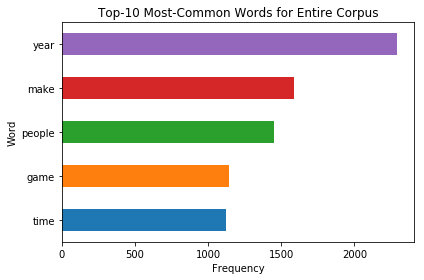

In [100]:
plot_ngrams(df_handle.tokens, n=1, file_name="most-common-unigram.png")

The most-common words for the entire corpus don't really give us a huge amount of insight about the data. The most-common word is "year" but this could be used in any of the contexts of the document categories. Similarly for the word "make", "people" and "time". However, one word that does stand out is "game", which we would primarily associate with sport. However, it is possible that this word is applicable to other categories too. We will investigate the most-common words per category later to see if the game-sport assocation is supported.

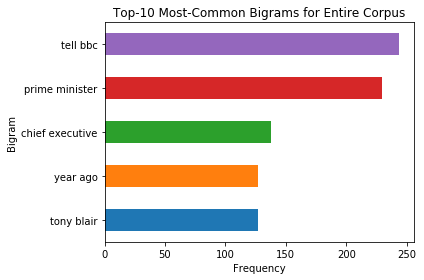

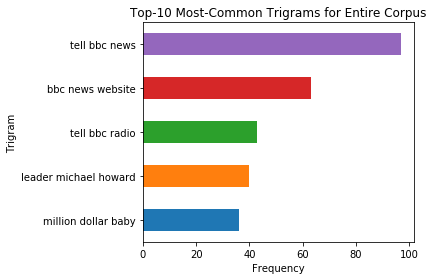

In [101]:
plot_ngrams(df_handle.tokens, n=2, file_name="most-common-bigram.png")
plot_ngrams(df_handle.tokens, n=3, file_name="most-common-trigram.png")

We get more information from analysing the bigrams and trigrams than the single words (also known as *unigrams*). For example, we see that the top bigram is "tell bbc" and the three most common trigrams are "tell bbc news", "bbc news website" and "bbc news radio". This would seem to suggest that the source of our news articles is BBC News. In fact, this is also supported by the reference to former-British Prime Minister, Tony Blair, and former-British Conservative Party Leader, Michael Howard, which are referenced by the fifth most common bigram and fourth most common trigram, respectively. 

Furthermore, we see that there are two bigrams that stand out for their association with particular document categories. "Prime Minister" is definitely associated with politics and "Chief Executive" is similarly associated with the business topic. We will investigate the importance of these n-grams later when dicussing the [most important terms and phrases](#most-important-n-grams) for classifying each topic. 

The fifth most common trigram is "million dollar baby". This could be a reference to the boxing film of the same name that won multiple Oscars in 2005. This trigram could definitely be associated with the entertainment category. However, seeing as it's a film that is related to sports, it could also be associated in some way to the sports category. We will investigate the [overlap between categories and their similarities](#category_similarity) later on in our data analysis.

### Category Frequency and Balance

Now, let's look at the labels that we have been provided with for each of the documents in our corpus. There are five possible categories (or *classes*) that the label can represent: sport, entertainment, politics, technology and business. We also refer to our class labels as the *target label* of each document.

We look at how many documents of each category appear in our dataset.

In [102]:
class_distribution = df_handle.groupby(df_handle.category).category.count()
class_distribution

category
business         356
entertainment    266
politics         292
sport            361
tech             282
Name: category, dtype: int64

We normalise these absolute numbers to get a breakdown of the percentage frequency of each category. This makes it easy to compare the figures. We also plot a line, in orange, for the mean frequency, this is the frequency that we expect all categories to have if the data is perfectly uniformly distibuted.

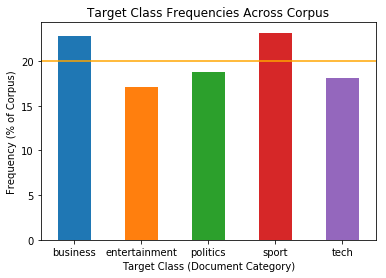

In [103]:
# Convert category frequency to a percentage of all categories.
class_distribution_normalised = (class_distribution / sum(class_distribution)) * 100

# Plot a line representing the mean frequency of all classes.
# This is the frequency each class would have if uniformly distributed.
mean_freq = 100 / len(class_distribution)

fig, axis = plt.subplots()
axis.axhline(y=mean_freq, color='orange')
class_distribution_normalised.plot.bar(ax=axis, rot=0)
axis.set_xlabel("Target Class (Document Category)")
axis.set_ylabel("Frequency (% of Corpus)")
axis.set_title("Target Class Frequencies Across Corpus")

plt.savefig('images/target-class-frequencies.png')
plt.show()

We see that we have a slighly unbalanced target class distribution. This means that not all target labels appear as often as each other. For example, the sport category is most common, whereas the entertainment category is the least common. When building our model, we need to take this into account, to make sure that we are not overly biasing our model based on the distribution of target classes in the training data. In extreme cases, our model could underfit the data and end up predicting the most common label (sport) each time. 

While this would be easy to spot and fix, it is possible that the class distribtion will affect the model in more subtle ways. One method we could use to avoid this would be to use the F-Measure as an evaluation metric for our models instead of just using Accuracy. We will investigate this later, in our section on model evaluation.

### Distribution of Document Lengths

Now, we look at some meta-statistics about each document. We compare the length of each document as well as the number of unique words in each document. We breakdown this analysis per-target class.

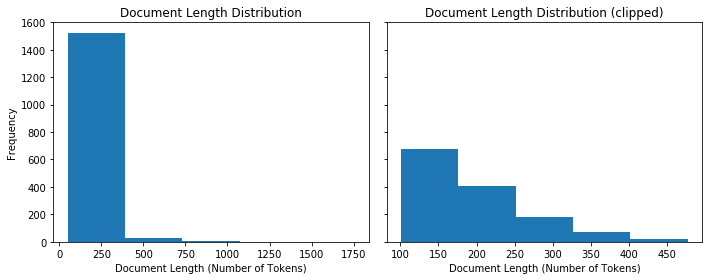

In [104]:
df_handle['document_length'] = df_handle.tokens.apply(len)

fig, axis = plt.subplots(1, 2, sharey=True)

df_handle.plot.hist(by='document_length', bins=5, ax=axis[0], figsize=(10,4), legend=None)
axis[0].set_xlabel("Document Length (Number of Tokens)")
axis[0].set_title("Document Length Distribution")

clipped_content_length_data = df_handle[(df_handle.document_length > 100) & (df_handle.document_length < 500)]
clipped_content_length_data.plot.hist(by='document_length', bins=5, ax=axis[1], figsize=(10, 4), legend=None)
axis[1].set_xlabel("Document Length (Number of Tokens)")
axis[1].set_title("Document Length Distribution (clipped)")

plt.tight_layout()
plt.savefig("images/document-length-distribution.png")
plt.show()

From the first histogram on the left, we see that the overwhelming majority of documents have between 100 and 500 words. We don't get a huge amount of information from this plot so we replot the data, except that we filter the dataset so that we only include documents whose length is within this interval. This process is known as *clipping*. The clipped data is plotted on the right histogram.

From the second histogram, we get more useful data. We see most of the documents have a length between 100 and 200 characters. It is important that we are aware that the distribution of the lengths of each document is not uniform. 

We also break this down for each document category.

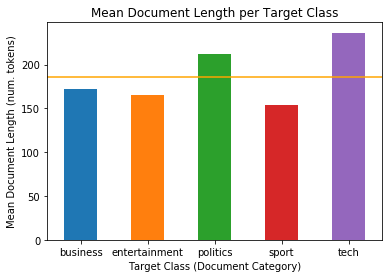

In [105]:
doc_length_per_class = df_handle.groupby(df_handle.category).document_length.mean()

fig, axis = plt.subplots()

doc_length_per_class.plot.bar(ax=axis, rot=0)

# We plot the average document length for reference.
mean_doc_length = df_handle['document_length'].mean()
axis.axhline(y=mean_doc_length, color='orange')

axis.set_xlabel("Target Class (Document Category)")
axis.set_ylabel("Mean Document Length (num. tokens)")
axis.set_title("Mean Document Length per Target Class")

plt.savefig("images/document-length-per-class.png")
plt.show()

Again, we see that we don't have uniform distribution of document length. This is important to recall, since, when we are using methods to vectorise the documents, if we don't take into account the documents' length, then we will be unfairly biasing longer or shorter documents (depending on the vectorising method). 

For example, if we are calculating the frequency of a term, comparing this across documents that have different lengths is unfair. A word that appears 10 times in a 50 word document is far more prominent that a word that appears 20 times in a 500 word document. So we need to make sure that we normalise our frequency calculation (i.e during TFIDF vectorisation) by the length of the doucment the term appears in. We will return to this point later when we are [doing the document vectorisation](#document-vectorisation).

<a id='document-vectorisation'></a>

# Document Vectorisation

In [106]:
# statistically check how important a word is to an article category
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(norm='l1')
document_token_strings = [' '.join(tokens) for tokens in df_handle.tokens]
tfidf_matrix = tfidf_vectorizer.fit_transform(document_token_strings).toarray()
df_handle['tfidf'] = list(tfidf_matrix)

In [107]:
type(df_handle.head().iloc[0].tfidf)

numpy.ndarray

In [108]:
df_handle = df_handle[['content', 'tokens', 'tfidf', 'category']]

In [109]:
df_handle

,content,tokens,tfidf,category
0,French boss to leave EADS The French co-head o...,"[french, bos, leave, eads, french, head, europ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",business
1,"Gamers could drive high-definition TV, films, ...","[gamers, drive, high, definition, tv, film, ga...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",tech
2,Stalemate in pension strike talks Talks aimed ...,"[stalemate, pension, strike, talk, talk, aim, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",politics
3,Johnny and Denise lose Passport Johnny Vaughan...,"[johnny, denise, lose, passport, johnny, vaugh...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",entertainment
4,Tautou 'to star in Da Vinci film' French actre...,"[tautou, star, da, vinci, film, french, actres...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",entertainment
5,Media seek Jackson 'juror' notes Reporters cov...,"[medium, seek, jackson, juror, note, reporter,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",entertainment
6,Horror film heads US box office A low-budget h...,"[horror, film, head, box, office, low, budget,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",entertainment
7,Kerr frustrated at victory margin Republic of ...,"[kerr, frustrate, victory, margin, republic, i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sport
8,US casino 'tricks' face ban in UK Controversia...,"[casino, trick, face, ban, uk, controversial, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",politics
9,Klinsmann issues Lehmann warning Germany coach...,"[klinsmann, issue, lehmann, warn, germany, coa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sport


In [110]:
df_handle.to_csv('./tfidf_data.csv', encoding='utf-8', index=False)

## Classification Models

In [111]:
tfidf_transformer = TfidfVectorizer(tokenizer=tokenize)
tfidf_content_vectors = tfidf_transformer.fit_transform(df_handle['content'])
X_train_data, X_test_data, y_train_labels, y_test_labels = train_test_split(tfidf_content_vectors, df_handle['category'], test_size=0.33)

In [159]:
class classificationModels():
    def knn_classifier(self, k, X_train_data, X_test_data, y_train_labels):
        # Create KNN Classifier
        knn = KNeighborsClassifier(n_neighbors=k)

        # Train the model using the training sets
        knn.fit(X_train_data, y_train_labels)

        # Predict the response for test dataset
        y_label_pred = knn.predict(X_test_data)
        
        # Calculate KNN accuracy
        knn_Acc = metrics.accuracy_score(y_test_labels, y_label_pred)
        
        # Calculate KNN error rate
        knn_Err = 1 - knn_Acc
        
        # print prediction labels, accuracy and error rate in a result dictionary
        results = {'Prediction Labels': "Prediction: " + y_label_pred, 'KNN Accuracy': 
                'Accuracy for KNN model (k=%d) is ' %k + "{:0.2f}%" .format(knn_Acc*100),'Knn Error Rate': 
                'Error rate for KNN model is {:0.2f}%'.format(knn_Err*100)}
        return results
    
    def NB_classifier(self, cv=crossVal_val, X_train_data, y_train_labels):
        scores = cross_val_score(MultinomialNB(), X_train_data, y_train_labels, cv=crossVal_val)
        return {'Naive Bayes scores': scores, 'Average of all generated Naive Bayes scores': np.mean(scores)}

In [160]:
models =  classificationModels()
k = 5
crossVal_val = 10
select_Model = {'knn': models.knn_classifier(k, X_train_data, X_test_data, y_train_labels), 
                'NB': models.NB_classifier(crossVal_val, X_train_data, y_train_labels)}

In [161]:
print(select_Model.get("NB"))

{'Naive Bayes scores': array([0.96226415, 0.94285714, 0.94285714, 0.96190476, 0.95238095,
       0.97142857, 0.94285714, 0.94174757, 0.97058824, 0.94117647]), 'Average of all generated Naive Bayes scores': 0.9530062143926997}


## Model and Cross-Validation Using Sklearn

Comparison of tokenization: custom tokenizer vs built in tokenizer.
Evaluated below on native bayes model
Initial results: custom tokenizer is better (~95-96.5% accuracy) vs the standard one (~92%)

In [ ]:
# testing simple native bayes with custom tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_handle)
tfidf_transformer = TfidfVectorizer(tokenizer=tokenize)
train_input_vectors = tfidf_transformer.fit_transform(train.content)
train_labels = train.category
scores = cross_val_score(MultinomialNB(), train_input_vectors, train_labels, cv=10)
print(scores)
print(np.mean(scores))

In [ ]:
# testing simple naive bayes with standard built in tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_handle)
tfidf_transformer = TfidfVectorizer()
train_input_vectors = tfidf_transformer.fit_transform(train.content)
train_labels = train.category
scores = cross_val_score(MultinomialNB(), train_input_vectors, train_labels, cv=10)
print(scores)
print(np.mean(scores))

In [ ]:
model = MultinomialNB(alpha=1.0)
model.fit(train_input_vectors, train_labels)

In [ ]:
for i in range(10):
    print("Article %s:" % i)
    print(df_handle.content[i].split('.')[0])
    print("Model prediction: %s" % model.predict(train_input_vectors[i])[0])
    print()

## More Sklearn Models

Try out more models from Sklearn and report their accuracy.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

names = [
    "Multinomial Naive Bayes",
    "Nearest Neighbors",
    "AdaBoost",
    "Linear SVM", 
    "RBF SVM",
    "Decision Tree",
    "Random Forest",  
#     "Naive Bayes",
#     "Neural Net",
#     "Gaussian Process",
         ]

classifiers = [
    MultinomialNB(alpha=1.0),
    KNeighborsClassifier(3),
    AdaBoostClassifier(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1), # took to long to run
#     GaussianProcessClassifier(1.0 * RBF(1.0)), # needs a 'dense matrix'?
#     GaussianNB(), # also needs a 'dense matrix'?
]

for name, classifier in zip(names, classifiers):
    k_folds = 10
    scores = cross_val_score(classifier, train_input_vectors, train_labels, cv=k_folds)
    average_accuracy = np.mean(scores)

    print("%s average accuracy (%d-fold x-val): %f" 
          % (name, k_folds, average_accuracy))

Results:
```
Multinomial Naive Bayes average accuracy (10-fold x-val): 0.950307
Nearest Neighbors average accuracy (10-fold x-val): 0.892863
AdaBoost average accuracy (10-fold x-val): 0.712065
Linear SVM average accuracy (10-fold x-val): 0.224502
RBF SVM average accuracy (10-fold x-val): 0.944214
Decision Tree average accuracy (10-fold x-val): 0.653080
Random Forest average accuracy (10-fold x-val): 0.323166
```

The Naive Bayes and RBF SVM are by far the most-promising. We should look into tweaking these models further to see if we can improve on the results.

The Nearest Neighbour model also performs well. We check to see which value of k provides the best results.

In [ ]:
best_k = 0
best_k_accuracy = 0

for k in range(1,100):
    k_folds = 10
    scores = cross_val_score(KNeighborsClassifier(k), train_input_vectors, train_labels, cv=k_folds)
    average_accuracy = np.mean(scores)
    
    if average_accuracy > best_k_accuracy:
        best_k_accuracy = average_accuracy
        best_k = k

    print("KNN (k=%d) average accuracy (%d-fold x-val): %f" 
          % (k, k_folds, average_accuracy))
    

print("Best k value is %d" % best_k)

The best-performing KNN uses k=26, accuracy = 0.904047. Still not as good as the NB or RBF SVM.

## Hyperparameter Optimization

### Naive Bayes Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

print('The search range is: ' + str(np.linspace(0.001,0.009,101)))
bayes_clf_val = MultinomialNB()
bayes_parameters = {'alpha': (np.linspace(0.001,0.009,101))}

In [ ]:
bayes_gs_clf = GridSearchCV(bayes_clf_val, param_grid = bayes_parameters, cv=10, scoring = 'accuracy')
bayes_gs_clf = bayes_gs_clf.fit(train_input_vectors, train_labels)
NB_parameters = bayes_gs_clf.best_params_
print('The best parameter is: ', NB_parameters['alpha'])

In [ ]:
bayes_gs_clf.grid_scores_

### KNN Classifier

In [ ]:
print('The search range is: ' + str(np.arange(1,100,1)))
knn_clf_val = KNeighborsClassifier()
knn_parameters = {'n_neighbors': (np.arange(1,100,1))}

In [ ]:
knn_gs_clf = GridSearchCV(knn_clf_val, param_grid = knn_parameters, cv=10, scoring = 'accuracy')
knn_gs_clf = knn_gs_clf.fit(train_input_vectors, train_labels)
KNN_parameters = knn_gs_clf.best_params_
print('The best parameter is: ', KNN_parameters['n_neighbors'])

In [ ]:
knn_gs_clf.grid_scores_

## Ensembles

#### Voting ensemble of the best three classifiers from before:

In [ ]:
import sklearn.ensemble

best_classifiers = [
    ('MultinomialNB', MultinomialNB(alpha=1.0)),
    ('KNN', KNeighborsClassifier(6)),
    ('SVM', SVC(gamma=2, C=1)),
]

voting_ensemble = sklearn.ensemble.VotingClassifier(best_classifiers)
scores = cross_val_score(voting_ensemble, train_input_vectors, train_labels, cv=10)
print("Average 10-fold cross-validation accuracy: %f" % np.mean(scores))

Results:

Average 10-fold cross-validation accuracy: 0.9486095170000001

This is slightly worse than MultinomialNB from our previous experiment. We have run these experiments several times and sometimes MultinomialNB is worse (~93% accuracy), but in general it seems that MultimonialNB is about as good as or better than the ensemble.

#### Bagging ensemble of the best classifier:

In [ ]:
base_classifier = MultinomialNB(alpha=1.0)
bagging_ensemble = sklearn.ensemble.BaggingClassifier(base_classifier)
scores = cross_val_score(bagging_ensemble, train_input_vectors, train_labels, cv=10)
print("Average 10-fold cross-validation accuracy: %f" % np.mean(scores))

Results:

Average 10-fold cross-validation accuracy: 0.926422

Again this is slightly worse than the standard MultinomialNB.

#### Bagging feature subspacing ensemble:

In [ ]:
feature_subspace_ensemble = sklearn.ensemble.BaggingClassifier(base_classifier, bootstrap=False, bootstrap_features=True)
scores = cross_val_score(feature_subspace_ensemble, train_input_vectors, train_labels, cv=10)
print("Average 10-fold cross-validation accuracy: %f" % np.mean(scores))

Results:

Average 10-fold cross-validation accuracy: 0.968237

#### Boosting ensemble of the best classifier:

In [ ]:
base_classifier = MultinomialNB(alpha=1.0)
boosting_classifier = sklearn.ensemble.AdaBoostClassifier(base_classifier)
scores = cross_val_score(boosting_classifier, train_input_vectors, train_labels, cv=10)
print("Average 10-fold cross-validation accuracy: %f" % np.mean(scores))

Results:

Average 10-fold cross-validation accuracy: 0.666899

This is significantly worse than standard MultinomialNB.

### Conclusion
A voting ensemble, bagging ensemble, and boosting ensemble all achieved worse results than a standard MultinomialNB model. For this reason we will not use an ensemble for our final model.

## TFIDF Vector Analysis

We now perform data analysis on the vectors that we have created for each of the documents. We want to explore trends or features of the documents and their categories to help improve our understanding of them. This will aid us in choosing and evaluating models in later sections.

We are going to analyse the following:
- Category Similarity
- Most Important N-Grams 

### PLEASE READ - Calculating TFIDF Vectors

Note(mm): I have redone this here since it incorporates l2 normalisation and using ngrams in the TFIDFVectoriser. I have discussed this above in the data analysis. However, this could affect our models' results (particularly the KNNs since we are adding lots more features through the bigrams and trigram) and so we should evaluate this before including it in the main 'thread'.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine each document's whole text content into a string.
all_tokens = [token for token in df_handle.tokens]
documents = [" ".join(token) for token in all_tokens]

# Normalize the TFIDF scores by the length of each document, including uni-, bi- and tri-grams.
tfidf_vectorizer = TfidfVectorizer(norm='l2', ngram_range=(1,3))

# Perform the TFIDF calculations.
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

tfidf_data = pd.DataFrame(tfidf_matrix.toarray(),
                        columns=[tfidf_vectorizer.get_feature_names()],
                        index=df_handle.index)

tfidf_data.head()

<!-- Anchor for internal links -->
<a id='category_similarity'></a>

### Category Similarity 

Now we turn our attention to computing which categories are most- and least-similar to each other. 
We do this with the following steps:
- Take each of our TFIDF document vectors
- Group the documents by their category
- Compute the mean TFIDF vector for each category
- Compute the cosine distance between each mean vector
- Calculate the closest vectors and the vectors furthest apart

We use cosine distance to as a measure of how similar each category is. Although distance measures how different each category is from each other, if we invert it then we get a similarity metric. This means that smaller distances imply greater similarity and larger distances mean less similarity. Cosine distance is a useful metric since it doesn't depend on the distance between the vectors in n-dimensional space, which could be unfairly biased by abnormally large vector-components. Instead, it depends on the angle between the vectors.

We start by calculating the mean TFIDF document vectors from the TFIDF matrix and put them into their own dataframe so that we can analyse them further.

In [ ]:
categories = df_handle.category.unique()
mean_vector_df = pd.DataFrame(index=tfidf_data.columns)

for category in categories:
    mean_vector = tfidf_data[df_handle.category == category].mean(axis=0)
    mean_vector_df[category] = mean_vector

In [ ]:
mean_vector_df.tail()

To calculate the distance between the categories, and not between the n-grams in the corpus, we need to transpose our data frame. This swaps the rows and the columns in the data frame. This means that the rows will now correspond to the categories and the columns to the n-grams.

We have done this because it is more efficient to add to a dataframe column-wise. Adding categories' data column-by-column and then transposing is more efficient than if we did the transposition first.

In [ ]:
# Transpose our data frame.
mean_vector_transpose = mean_vector_df.T

# Calculate cosine distance based on the tranposed data.
pairwise_cosine_distance = sklearn.metrics.pairwise_distances(mean_vector_transpose, metric='cosine')

pairwise_cosine_distance

We could read this matrix by eye, but this could get complicated. Instead, we define some helper functions to find the most-similar categories and the least-similar categories.

In [ ]:
def n_closest_categories(array, n):
    """
    Returns a list of tuples of the category-pairs that are most similar to each other.
    The number of tuples returned is decided by the size parameter, n.
    """
    return n_extreme_categories(array, n, multiplier=1)


def n_furthest_categories(array, n):
    """
    Returns a list of tuples of the category-pairs that are furthest away from each other.
    The number of tuples returned is decided by the size parameter, n.
    """
    return n_extreme_categories(array, n, multiplier=-1)


def n_extreme_categories(array, n, multiplier):
    """
    Return a list of tuples of the category pairs that have the most-extreme distances from 
    each other. Extreme can mean either smallest or largest distance from each other. 
    
    In the case of the calculating the largest, we sort our array in reverse. This means that
    we first have to multiply the array by -1, since numpy only provide an ascending-order 
    sorter.
   
    Note that we want to use built-in numpy library functions since they are most-efficient in 
    dealing with numpy arrays.
    """
    
    # We take the indices from 0 to 2n, with a step size of 2. This means that
    # we skip every second index, which will be the same value as the index before it,
    # given that the distance matrix is symmetric.
    # For example, for the largest n=2, we take the first and third maximum elements, 
    # skipping the second since it will be the same as the first.
    extreme_indices = np.argsort(multiplier * array.flatten())[0:2*n:2]

    extreme_categories = []
    
    for ind in extreme_indices:
        two_d_index = np.unravel_index(ind, array.shape)
        
        # Convert the tuple of indices to a tuple of the corresponding categories.
        converted_tuple = tuple(map(lambda c: categories[c], two_d_index))
        extreme_categories.append(converted_tuple)
        
    return extreme_categories

In [ ]:
n_furthest_categories(pairwise_cosine_distance, n=2)

To calculate the most-similar category-pairs we need to remove the zero values from our pairwise-distance array. The values are 0 when comparing a category to itself, but this doens't give us any valuable information. 

Instead, we will copy the pairwise-distance array and transform the zero-values to infinity.

In [ ]:
nonzero_distances = pairwise_cosine_distance.copy()
nonzero_distances[nonzero_distances == 0] = float("inf")

n_closest_categories(nonzero_distances, n=2)

So the two most similar category-pairs are:
- politics and buiness 
- business and tech

And the two least similar category-pairs are:
- sport and business
- entertainment and business

It is important the we recognise and compute these similarities when evaluating our model. It is a basic requirement that the model is able to distinguish between the least-similar categories of documents. In order to have an optimal model, it also needs to be able to tell apart the most-similar categories. 

However, when evaluating models, it is important to recognise that the category-pairs listed above are the most similar and, therefore, the hardest to tell apart. This means that we can still have a very good, high performance model, even if it is slightly confused between the most similar document categories.

It is also interesting to note that the category of business is included in all of the most- and least-similar category-pairs. This indicates how complex and varied the defining-features of particular categories are.

<a id="most-important-n-grams"></a>
### Most-Important N-Grams

Now we look at which n-grams are the most-important in our dataset. We define importance by the TFIDF metric. By investigating the most important n-grams we should be able to determine the terms that are most indicative of a document's category.

#### Across Entire Corpus

First of all, though, let's look at the most important n-grams throughout the entire corpus.

In [ ]:
# Calculate the mean TFIDF vector for the entire corpus.
tfidf_mean = tfidf_data.mean(axis=0)

In [ ]:
# Find the 10 largest TFIDF-valued terms. These can be uni-, bi-, or tri-grams.
most_important_words = tfidf_mean.nlargest(10)

## TODO(mm) worth comparing with the most common words?
most_important_words

We don't really get any valuable information from this list. However, it is interesting to note that all of the top ten n-grams are unigrams. This shows that bigrams and trigrams are much less indicative of a document's category than single words.

Let's look at the most important bigram and the most important trigram.

In [ ]:
tfidf_mean[tfidf_mean.index.map(lambda x: len(x.split())) == 2].nlargest(1)

In [ ]:
tfidf_mean[tfidf_mean.index.map(lambda x: len(x.split())) == 3].nlargest(1)

We see that the most important bigram is an order of magnitude (10 times) less important than the top unigram. The most important trigram is an order of magnitude less important than that. 

This is interesting because it shows that, for n-grams longer than unigrams, the relative infrequency (TF)  (due to having to match multiple words in a pattern) is not outweighed by the inverse document frequency (IDF). The TFIDF values are lower as a result.

#### Within Each Category

Now, we look at the most important words within each category, instead of across the entire corpus.

Note that we have already calculated the mean TFIDF document vectors for each category in the [Category Similarity](#category_similarity) section above. We are going to reuse them since there is no need to duplicate the data, which will increase the computational time of our notebook unnecesarily.

In [ ]:
fig, axis = plt.subplots(len(categories), sharex=True)

# Keep a list of all terms that appear in the top ten for each category.
most_important_terms = []

for i in range(len(categories)):
    category_vector = mean_vector_transpose.iloc[i]
    
    category_vector.nlargest(10).plot.barh(ax=axis[i], figsize=(10, 15))
    
    most_important_terms.extend(category_vector.nlargest(10).index)
    
    axis_title = "Most Important N-Grams for Category %s"
    axis[i].set_title(axis_title % category_vector.name.title())
    
axis[len(categories) - 1].set_xlabel("Importance (TFIDF Value)")

plt.tight_layout()
plt.savefig("images/most-important-terms-per-category.png")
plt.show()

These bar charts give us a wealth of insight into what is the defining words for each category. For example, by far the most important term is "film", which is indicative of the entertainment category. This means that a good model will identify the occurences of the word "film" in a document and make it more likely to classify that document as being about entertainment. 

We also get lots of information about the key words in each category. To start with, they are all unigrams (the lack of bigram or trigram phrases is discussed above). It is also interesting to note that the categories appear to be fairly disjoint from each other, based on their top ten most important words. We can see this by the fact that the only terms that is in the top ten in more than one category are:
- "game", appearing for both the sport and tech categories
- "year", appearing for both the business and entertainment categories

We show this, computationally, below:

In [ ]:
import collections
collections.Counter(most_important_terms).most_common(5)

However, when considering all terms, not just the top ten, we have seen that the categories are more aligned. This is discussed in the [Category Similarity section](#category_similarity)  above.